## How is VIX calculated

VIX, or the annualized **30-day implied volatility of the S&P 500**, is calculated throughout each trading day by averaging the weighted prices of a specific group of S&P 500 call and put options. As with other S&P DJI indices, the methodology used to calculate VIX is rigorous and transparent, though it differs from other indices in that it measures volatility rather than changes in security prices.

The VIX methodology specifies that **S&P 500 option contracts with more than 23 days and less than 37 days to expiration are used to calculate the index**. Both standard and weekly option contracts with expirations in the 23 to 37 day range are eligible.

Once a week, the options used to calculate VIX roll to new contract maturities. For example, on the second Tuesday in October, VIX would be calculated using two sets of options—a “near-term” option expiring 24 days later and a “next-term” option expiring 31 days later. On the following day, the options that expire in 30 calendar days would become the near-term options in the calculation and SPX options that expire in 37 calendar days would become the new next-term options. In this example, the near-term options would be standard S&P 500 options with 25 days to expiration, whereas the next-term options would be weekly options with 32 days to expiration.

As each VIX calculation begins, the first step is determining which option contracts, with strike prices higher and lower than the current SPX level, will be included. The number of contracts may vary from calculation to calculation, but **typically includes more than 100 puts and calls.** To make the cut, **the contracts must have current non-zero bid and ask prices, or what is known as a quote**, from investors willing to buy or sell at that price. The further a strike price is from the current SPX level, the less likelihood there is of finding a quote, and contracts without quotes are excluded. At the point that two contracts with consecutive strike prices do not have quotes, no additional contracts are eligible for inclusion and the components are set.

In the next step, the options contracts that have been selected are weighted to ensure that each has the required impact on the calculation. The VIX formula is designed to combine options in a way that means that **subsequent movements in the VIX are dependent only on the volatility of the underlying**. Changes in the S&P 500 level, dividends, interest rates, or other factors have no impact because they have been balanced out and removed. The precise justification for the weighting is technical, but it results in a system that **weights each option in inverse proportion to the square of the option strike price**. Accordingly, **VIX is more sensitive to changes in the prices of options with lower strikes and less sensitive to options with higher strikes**.

https://www.spglobal.com/spdji/en/vix-intro/#:~:text=VIX%2C%20or%20the%20annualized%2030,500%20call%20and%20put%20options

## This part is descriptive analysis on historical data of the VIX index to figure out its time series patterns and relationship with other variables 

## Data import and transformation

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
#from statsmodels.tsa.stattools import pperron
from hurst import compute_Hc
import seaborn as sns
import arch
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import numpy as np 
from sklearn.tree import DecisionTreeRegressor
import math

In [2]:
raw = pd.read_excel('Dataset.xlsx')
print('The data include',len(raw), 'daily observations.')

The data include 7815 daily observations.


Data runs from 1993 till 2023

In [3]:
raw['vix_return'] = raw['vix_first_difference'] / raw['vix']
raw['vix_return_lag'] = raw['vix_return'].shift(1)

In [4]:
raw['sp_volume_first_difference'] = raw['sp_volume'].diff()
raw['sp_volume_change'] = raw['sp_volume_first_difference']/raw['sp_volume']
raw['sp_volume_change_lag'] = raw['sp_volume_change'].shift(1)

In [5]:
raw['dxy_return'] = raw['dxy_first_difference']/ raw['dxy']
raw['dxy_return_lag'] = raw['dxy_return'].shift(1)

In [6]:
raw['wti_future_first_difference'] = raw['wti_future'].diff()
raw['wti_future_return'] = raw['wti_future_first_difference']/raw['wti_future']
raw['wti_future_return_lag'] = raw['wti_future_return'].shift(1)

In [7]:
raw['ust_10y_per_change'] = raw['ust_10y_first_difference'] / raw['ust_10y']
raw['ust_10y_per_change_lag'] = raw['ust_10y_per_change'].shift(1)

In [8]:
raw = raw.iloc[2:].reset_index(drop=True)

In [9]:
raw.columns

Index(['Date', 'vix', 'vix_log', 'vix_first_difference', 'sp', 'sp_volume',
       'sp_return', 'ust_10y', 'ust_10y_first_difference', 'dxy',
       'dxy_first_difference', 'wti_future', 'vix_lag', 'vix_log_lag',
       'vix_first_difference_lag', 'sp_lag', 'sp_volume_lag', 'sp_return_lag',
       'ust_10y_lag', 'ust_10y_first_difference_lag', 'dxy_lag',
       'dxy_first_difference_lag', 'wti_future_lag', 'vix_return',
       'vix_return_lag', 'sp_volume_first_difference', 'sp_volume_change',
       'sp_volume_change_lag', 'dxy_return', 'dxy_return_lag',
       'wti_future_first_difference', 'wti_future_return',
       'wti_future_return_lag', 'ust_10y_per_change',
       'ust_10y_per_change_lag'],
      dtype='object')

In [10]:
raw.head()

,Date,vix,vix_log,vix_first_difference,sp,sp_volume,sp_return,ust_10y,ust_10y_first_difference,dxy,...,sp_volume_first_difference,sp_volume_change,sp_volume_change_lag,dxy_return,dxy_return_lag,wti_future_first_difference,wti_future_return,wti_future_return_lag,ust_10y_per_change,ust_10y_per_change_lag
0,1993-01-06,13.37,2.593013,0.02,434.52,218849300,0.000414,6.63,0.02,93.07,...,51006200.0,0.233065,0.166105,0.004620,-0.008851,NaN,NaN,NaN,0.003017,0.001513
1,1993-01-07,14.72,2.689207,1.35,430.73,231186700,-0.008722,6.76,0.13,93.17,...,12337400.0,0.053366,0.233065,0.001073,0.004620,NaN,NaN,NaN,0.019231,0.003017
2,1993-01-08,13.77,2.622492,-0.95,429.05,191369800,-0.003900,6.75,-0.01,93.45,...,-39816900.0,-0.208063,0.053366,0.002996,0.001073,NaN,NaN,NaN,-0.001481,0.019231
3,1993-01-11,12.86,2.554122,-0.91,430.95,151430800,0.004428,6.71,-0.04,92.69,...,-39939000.0,-0.263744,-0.208063,-0.008199,0.002996,NaN,NaN,NaN,-0.005961,-0.001481
4,1993-01-12,12.78,2.547881,-0.08,431.04,169692300,0.000209,6.72,0.01,92.89,...,18261500.0,0.107615,-0.263744,0.002153,-0.008199,NaN,NaN,NaN,0.001488,-0.005961


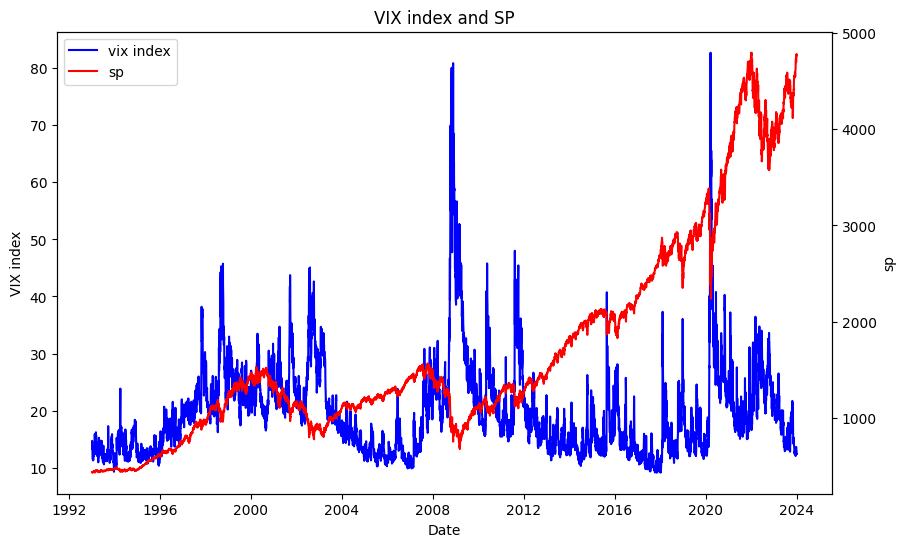

In [11]:
# Plotting with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot lines for Variable1 and Variable2 on the primary y-axis
ax1.plot(raw['Date'], raw['vix'], label='vix index', color='blue')

# Set labels for the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX index', color='black')
ax1.tick_params('y', colors='black')

# Create a secondary y-axis for Variable3
ax2 = ax1.twinx()
ax2.plot(raw['Date'], raw['sp'], label='sp', color='red')
ax2.set_ylabel('sp', color='black')
ax2.tick_params('y', colors='black')

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.title('VIX index and SP')
plt.show()

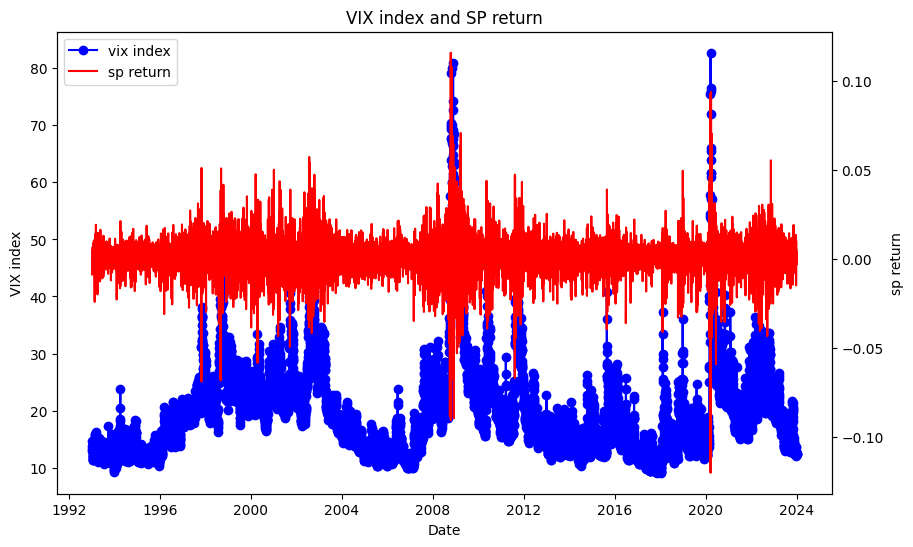

In [12]:
# Plotting with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot lines for Variable1 and Variable2 on the primary y-axis
ax1.plot(raw['Date'], raw['vix'], label='vix index', marker = 'o', color='blue')

# Set labels for the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX index', color='black')
ax1.tick_params('y', colors='black')

# Create a secondary y-axis for Variable3
ax2 = ax1.twinx()
ax2.plot(raw['Date'], raw['sp_return'], label='sp return', color='red')
ax2.set_ylabel('sp return', color='black')
ax2.tick_params('y', colors='black')

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.title('VIX index and SP return')
plt.show()

### Consistent with common belief, VIX tends to go up when S&P 500 returns fluctuate, and when S&P 500 index falls. VIX means the options implied volatility of S&P500 in 30 days time

## Descriptive analysis of vix data and its transformations
The aim is to find out more on its time series property and patterns for time series prediction

## Descriptive analysis of the VIX index

In [13]:
vix_1 = raw[['Date','vix']][:4000]
vix_2 = raw[['Date','vix']][4000:]
vix_full = raw[['Date','vix']]

In [14]:
dfs = [vix_1, vix_2, vix_full]
col_names = ['first_half','second_half','full_sample']
describe = pd.DataFrame()

In [15]:
for i in range(len(dfs)):
    df = dfs[i]
    col_name = col_names[i]
    describe_1 = pd.DataFrame(df['vix'].describe())
    describe_1 = describe_1.rename(columns={'vix':col_name})
    describe = pd.concat([describe,describe_1], axis=1)

describe

,first_half,second_half,full_sample
count,4000.000000,3813.000000,7813.000000
mean,19.607660,19.684915,19.645363
std,7.832308,8.456093,8.142276
min,9.310000,9.140000,9.140000
25%,13.420000,13.850000,13.670000
50%,18.550000,17.340000,17.840000
75%,23.462500,22.790000,23.190000
max,80.860000,82.690000,82.690000


In [16]:
describe.loc['skew'] = [skew(df['vix']) for df in dfs] 
describe.loc['kurtosis'] = [kurtosis(df['vix']) for df in dfs] 
# this outputs p-value of the jarque-bera test, p<0.05 means the distribution is not normal
describe.loc['Jarque-Bera'] = [jarque_bera(df['vix'])[1] for df in dfs] 
describe.loc['ADF'] = [adfuller(df['vix'], autolag='AIC')[1] for df in dfs] 
describe.loc['KPSS'] = [kpss(df['vix'])[1] for df in dfs] 
describe.loc['R/S'] = [compute_Hc(df['vix'], kind='price', simplified = False)[0] for df in dfs] 

C:\Users\User\AppData\Local\Temp\ipykernel_26872\10185607.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  describe.loc['KPSS'] = [kpss(df['vix'])[1] for df in dfs]
C:\Users\User\AppData\Local\Temp\ipykernel_26872\10185607.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  describe.loc['KPSS'] = [kpss(df['vix'])[1] for df in dfs]


In [17]:
describe

,first_half,second_half,full_sample
count,4000.000000,3.813000e+03,7813.000000
mean,19.607660,1.968491e+01,19.645363
std,7.832308,8.456093e+00,8.142276
min,9.310000,9.140000e+00,9.140000
25%,13.420000,1.385000e+01,13.670000
50%,18.550000,1.734000e+01,17.840000
75%,23.462500,2.279000e+01,23.190000
max,80.860000,8.269000e+01,82.690000
skew,2.109578,2.131893e+00,2.127433
kurtosis,9.094517,6.942416e+00,7.948403


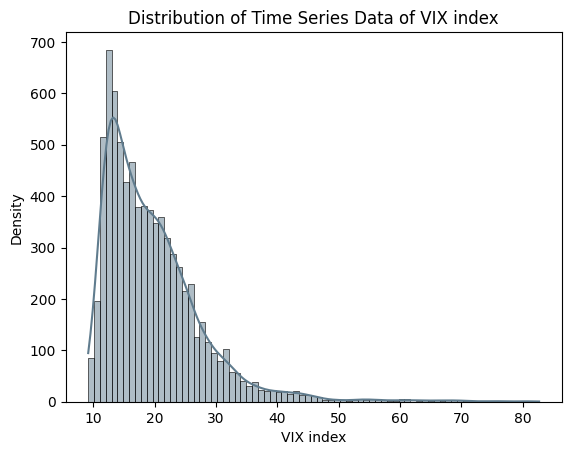

In [18]:
sns.histplot(vix_full['vix'], bins='auto', kde=True, color='#607c8e')
plt.title('Distribution of Time Series Data of VIX index')
plt.xlabel('VIX index')
plt.ylabel('Density')
plt.show()

### Analysis of the descriptive stats - vix index
All 3 periods have **positive skew and large excess kurtosis** <br>

Jarque-Bera test p value all < 0.05, this means the series is **not normally distributed** <br>

ADF test strongly rejects null hypothesis for second half and full sample, cannot reject for first half. This means **the first half is non-stationary and second half is stationary. This reflects regime shift in VIX index** <br>

KPSS test rejects null for first half and second half, fails to reject null for full sample. This means **first half and second half are both not trend stationary whereas the full sample is trend stationary**. Both tests conclude that the full sample is trend stationary and first half is not stationary. They do not agree regarding wether the second half is stationary <br>

**R/S test results are all < 0.5. There is not enough evidence for long memory**

## Describe first difference of vix index

In [19]:
vixdiff_1 = raw[['Date','vix_first_difference']][:4000]
vixdiff_2 = raw[['Date','vix_first_difference']][4000:]
vixdiff_full = raw[['Date','vix_first_difference']]

In [20]:
diffdfs = [vixdiff_1, vixdiff_2, vixdiff_full]
col_names = ['first_half','second_half','full_sample']
describediff = pd.DataFrame()

In [21]:
for i in range(len(diffdfs)):
    diffdf = diffdfs[i]
    col_name = col_names[i]
    describe_1 = pd.DataFrame(diffdf['vix_first_difference'].describe())
    describe_1 = describe_1.rename(columns={'vix_first_difference':col_name})
    describediff = pd.concat([describediff,describe_1], axis=1)

describediff

,first_half,second_half,full_sample
count,4000.000000,3813.000000,7813.000000
mean,0.016877,-0.017941,-0.000115
std,1.442091,1.880973,1.670728
min,-17.360000,-17.640000,-17.640000
25%,-0.592500,-0.780000,-0.680000
50%,-0.030000,-0.110000,-0.070000
75%,0.570000,0.570000,0.570000
max,16.540000,24.860000,24.860000


In [22]:
describediff.loc['skew'] = [skew(diffdf['vix_first_difference']) for diffdf in diffdfs] 
describediff.loc['kurtosis'] = [kurtosis(diffdf['vix_first_difference']) for diffdf in diffdfs] 
describediff.loc['Jarque-Bera'] = [jarque_bera(diffdf['vix_first_difference'])[1] for diffdf in diffdfs] 
describediff.loc['ADF'] = [adfuller(diffdf['vix_first_difference'], autolag = 'AIC')[1] for diffdf in diffdfs] 
describediff.loc['KPSS'] = [kpss(diffdf['vix_first_difference'])[1] for diffdf in diffdfs] 
# describediff.loc['R/S'] = [compute_Hc(diffdf['vix_first_difference'], kind='price', simplified = False)[0] for diffdf in diffdfs]

C:\Users\User\AppData\Local\Temp\ipykernel_26872\1366341660.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describediff.loc['KPSS'] = [kpss(diffdf['vix_first_difference'])[1] for diffdf in diffdfs]
C:\Users\User\AppData\Local\Temp\ipykernel_26872\1366341660.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describediff.loc['KPSS'] = [kpss(diffdf['vix_first_difference'])[1] for diffdf in diffdfs]
C:\Users\User\AppData\Local\Temp\ipykernel_26872\1366341660.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describediff.loc['KPSS'] = [kpss(diffdf['vix_first_difference'])[1] for diffdf in diffdfs]


In [23]:
describediff

,first_half,second_half,full_sample
count,4.000000e+03,3.813000e+03,7.813000e+03
mean,1.687750e-02,-1.794125e-02,-1.151926e-04
std,1.442091e+00,1.880973e+00,1.670728e+00
min,-1.736000e+01,-1.764000e+01,-1.764000e+01
25%,-5.925000e-01,-7.800000e-01,-6.800000e-01
50%,-3.000000e-02,-1.100000e-01,-7.000000e-02
75%,5.700000e-01,5.700000e-01,5.700000e-01
max,1.654000e+01,2.486000e+01,2.486000e+01
skew,2.906080e-01,1.992689e+00,1.474995e+00
kurtosis,2.219017e+01,2.616802e+01,2.696580e+01


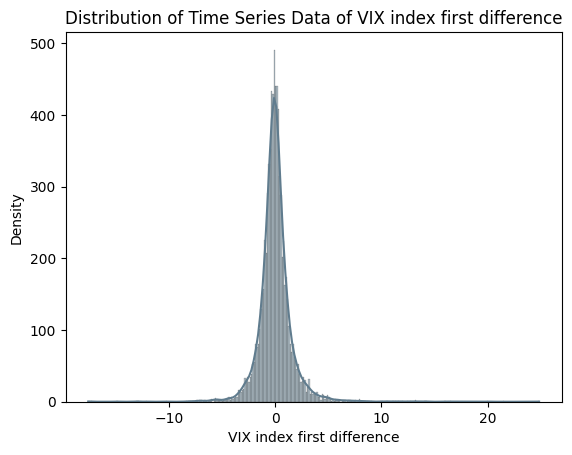

In [24]:
sns.histplot(vixdiff_full['vix_first_difference'], bins='auto', kde=True, color='#607c8e')
plt.title('Distribution of Time Series Data of VIX index first difference')
plt.xlabel('VIX index first difference')
plt.ylabel('Density')
plt.show()

### Analysis of the descriptive stats - vix first difference
All 3 periods have small positive skew and excess kurtosis <br>

Jarque-Bera test p value all < 0.05, this means the series is **not normally distributed** <br>

ADF test strongly rejects null hypothesis for all 3 periods. This means **stationarity in all 3 periods**. <br>

KPSS test rejects null for all 3 periods at alpha=0.05. This means all 3 periods are **not trend stationary. ADF and KPSS tests contradict each other. inconclusive results** 

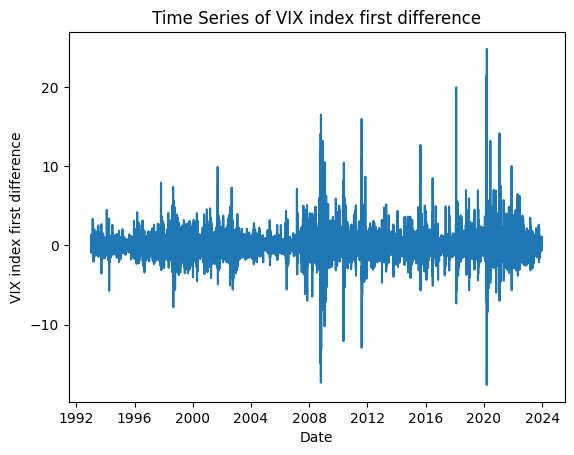

In [25]:
plt.plot(vixdiff_full['Date'], vixdiff_full['vix_first_difference'])
plt.title('Time Series of VIX index first difference')
plt.xlabel('Date')
plt.ylabel('VIX index first difference')
plt.show()
# the plot shows volatility clustering


# the plot shows volatility clustering## Describe Percentage change in VIX

In [26]:
vixret_1 = raw[['Date','vix_return']][:4000]
vixret_2 = raw[['Date','vix_return']][4000:]
vixret_full = raw[['Date','vix_return']]

In [27]:
retdfs = [vixret_1, vixret_2, vixret_full]
col_names = ['first_half','second_half','full_sample']
describeret = pd.DataFrame()

In [28]:
for i in range(len(retdfs)):
    retdf = retdfs[i]
    col_name = col_names[i]
    describe_1 = pd.DataFrame(retdf['vix_return'].describe())
    describe_1 = describe_1.rename(columns={'vix_return':col_name})
    describeret = pd.concat([describeret,describe_1], axis=1)

describeret

,first_half,second_half,full_sample
count,4000.000000,3813.000000,7813.000000
mean,-0.001241,-0.003290,-0.002241
std,0.057906,0.073480,0.065972
min,-0.349686,-0.419903,-0.419903
25%,-0.034579,-0.044361,-0.039258
50%,-0.001931,-0.007080,-0.004127
75%,0.031414,0.033457,0.032152
max,0.391043,0.536174,0.536174


In [29]:
describeret.loc['skew'] = [skew(retdf['vix_return']) for retdf in retdfs] 
describeret.loc['kurtosis'] = [kurtosis(retdf['vix_return']) for retdf in retdfs] 
describeret.loc['Jarque-Bera'] = [jarque_bera(retdf['vix_return'])[1] for retdf in retdfs] 
describeret.loc['ADF'] = [adfuller(retdf['vix_return'], autolag = 'AIC')[1] for retdf in retdfs] 
describeret.loc['KPSS'] = [kpss(retdf['vix_return'])[1] for retdf in retdfs] 

C:\Users\User\AppData\Local\Temp\ipykernel_26872\2771477014.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describeret.loc['KPSS'] = [kpss(retdf['vix_return'])[1] for retdf in retdfs]
C:\Users\User\AppData\Local\Temp\ipykernel_26872\2771477014.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describeret.loc['KPSS'] = [kpss(retdf['vix_return'])[1] for retdf in retdfs]


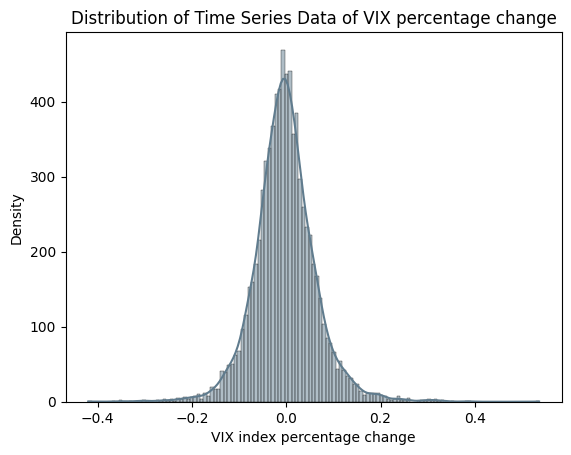

In [30]:
sns.histplot(vixret_full['vix_return'], bins='auto', kde=True, color='#607c8e')
plt.title('Distribution of Time Series Data of VIX percentage change')
plt.xlabel('VIX index percentage change')
plt.ylabel('Density')
plt.show()

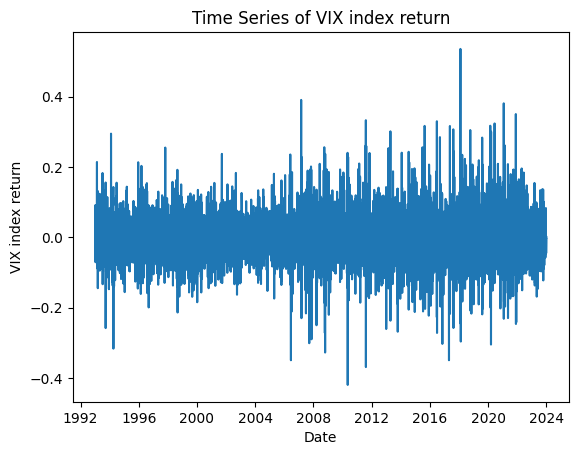

In [31]:
plt.plot(raw['Date'], raw['vix_return'])
plt.title('Time Series of VIX index return')
plt.xlabel('Date')
plt.ylabel('VIX index return')
plt.show()

# no clear pattern

In [32]:
describeret

,first_half,second_half,full_sample
count,4.000000e+03,3813.000000,7813.000000
mean,-1.241168e-03,-0.003290,-0.002241
std,5.790639e-02,0.073480,0.065972
min,-3.496855e-01,-0.419903,-0.419903
25%,-3.457873e-02,-0.044361,-0.039258
50%,-1.930953e-03,-0.007080,-0.004127
75%,3.141384e-02,0.033457,0.032152
max,3.910431e-01,0.536174,0.536174
skew,2.749634e-02,0.440808,0.295779
kurtosis,2.834583e+00,3.431904,3.585586


### Analysis of the descriptive stats - vix percentage change
All 3 periods have **small positive skew and excess kurtosis** <br>

Jarque-Bera test p value all < 0.05, this means the series is **not normally distributed** <br>

ADF test strongly rejects null hypothesis for all 3 periods. This means **stationarity in all 3 periods**. <br>

KPSS test cannot reject null for all 3 periods at alpha=0.05. This means all 3 periods are **trend stationary. ADF and KPSS tests both support stationarity**. This is importance for time series models. Thus, **vix percentage change is chosen for time series predictions.**

## Describe log VIX index

In [28]:
vixlog_1 = raw[['Date','vix_log']][:4000]
vixlog_2 = raw[['Date','vix_log']][4000:]
vixlog_full = raw[['Date','vix_log']]

In [29]:
logdfs = [vixlog_1, vixlog_2, vixlog_full]
col_names = ['first_half','second_half','full_sample']
describelog = pd.DataFrame()

In [30]:
for i in range(len(logdfs)):
    logdf = logdfs[i]
    col_name = col_names[i]
    describe_1 = pd.DataFrame(logdf['vix_log'].describe())
    describe_1 = describe_1.rename(columns={'vix_log':col_name})
    describelog = pd.concat([describelog,describe_1], axis=1)

describelog

,first_half,second_half,full_sample
count,4000.000000,3813.000000,7813.000000
mean,2.910444,2.908377,2.909435
std,0.351585,0.361230,0.356303
min,2.231089,2.212660,2.212660
25%,2.596746,2.628285,2.615204
50%,2.920470,2.853016,2.881443
75%,3.155403,3.126322,3.143721
max,4.392719,4.415099,4.415099


In [31]:
describelog.loc['skew'] = [skew(logdf['vix_log']) for logdf in logdfs] 
describelog.loc['kurtosis'] = [kurtosis(logdf['vix_log']) for logdf in logdfs] 
describelog.loc['Jarque-Bera'] = [jarque_bera(logdf['vix_log'])[1] for logdf in logdfs] 
describelog.loc['ADF'] = [adfuller(logdf['vix_log'],autolag='AIC')[1] for logdf in logdfs] 
describelog.loc['KPSS'] = [kpss(logdf['vix_log'])[1] for logdf in logdfs] 
describelog.loc['R/S'] = [compute_Hc(logdf['vix_log'], kind='price', simplified = False)[0] for logdf in logdfs]  

C:\Users\User\AppData\Local\Temp\ipykernel_25244\127392688.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  describelog.loc['KPSS'] = [kpss(logdf['vix_log'])[1] for logdf in logdfs]
C:\Users\User\AppData\Local\Temp\ipykernel_25244\127392688.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  describelog.loc['KPSS'] = [kpss(logdf['vix_log'])[1] for logdf in logdfs]


In [32]:
describelog

,first_half,second_half,full_sample
count,4.000000e+03,3.813000e+03,7.813000e+03
mean,2.910444e+00,2.908377e+00,2.909435e+00
std,3.515852e-01,3.612299e-01,3.563034e-01
min,2.231089e+00,2.212660e+00,2.212660e+00
25%,2.596746e+00,2.628285e+00,2.615204e+00
50%,2.920470e+00,2.853016e+00,2.881443e+00
75%,3.155403e+00,3.126322e+00,3.143721e+00
max,4.392719e+00,4.415099e+00,4.415099e+00
skew,4.902140e-01,7.557447e-01,6.251174e-01
kurtosis,1.134809e-01,4.986791e-01,3.124741e-01


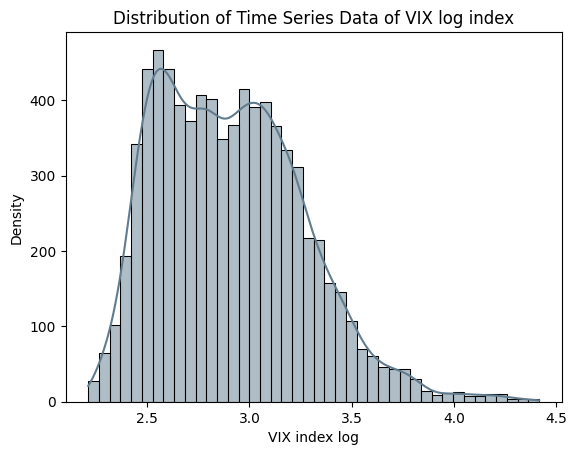

In [33]:
sns.histplot(vixlog_full['vix_log'], bins='auto', kde=True, color='#607c8e')
plt.title('Distribution of Time Series Data of VIX log index')
plt.xlabel('VIX index log')
plt.ylabel('Density')
plt.show()

### Analysis of the descriptive stats - vix log
All 3 periods have **small positive skew and excess kurtosis** <br>

Jarque-Bera test p value all < 0.05, this means the series is **not normally distributed** <br>

ADF test strongly rejects null hypothesis for second half and full sample, cannot reject for first half. This means the **first half is non-stationary and second half is stationary.** This reflects regime shift in VIX index. Same as the vix series. <br>

KPSS test rejects null for all 3 periods at alpha=0.05. This means **all 3 periods are not trend stationary**.Both tests conclude that first half is not stationary. **They do not agree regarding wether the second half and full sample are stationary. Results are inconclusive.** <br>

R/S test results are all < 0.5. There is **not enough evidence for long memory.**

## Conclusion and Summary from Descriptive Analysis

The lack of long-memory as evidenced in the R/S ratio means the heterogeneous autoregressive model (HAR) is not suitable for time series prediction.

Among the 4 transformed VIX variables (VIX index itself, log, first difference, percentage change), only the percentage change in VIX has conclusive nonstationarity. Thus, it would be the best variable to choose for time series predictive models.

There seems to be a correlation between S&P500 index as well as return and the VIX index. This prompts us to use regression to predict VIX as well.

In [ ]:
jupyter nbconvert --to script VIX Prediction p1 des.ipynb